## context for may 15 session

- we find it a little difficult to find datasets when we need them, so we want to build a tool to fix this
- we want smart search on dataset descriptions
- "smart" part of smart search will come from AI
- last class we used AI in a very rudimentary way - and it seemed to do what we need it to do. 
- however the approach we took does not scale (we can't copy paste ALL dataset descriptions into the context window of GPT 4 every time we want it to find us a dataset)

### the "real" approach

- we're going to use embeddings

**what are embeddings used for**

- calculating similarity between chunks of language
- chunks of language are represented as vectors (8,2) (7,3) <- these would be examples of 2 dimensional embeddings
- once we have vectors we can calculate distances between them. (look up the formula for the distance between two vectors)
- vectors (representing chunks of language) are similar when the distance between them is relatively small, and vice versa

e.g.

"i am tired"  "i am exhausted" "i am energetic"

**what actually are embeddings**

- high level: numeric representation of semantic strings (most prevalent example is natural language (e.g. english) but also we can use embeddings to represent DNA, and any other string of symbols that together have meaning).

**how we will implement**

- we will not figure out what the vectors should on our own
- in other words, we will not train an embedding model
- we're going to use a pre-trained model that openai offers us (for a fee)

- we're going to generate a vector to represent each dataset description
- we're going to save them somehow (a few options here)

- user (us/me) will write a sentence (could be longer) to describe what kind of dataset they are looking for.
- we will vectorize the user input

- user vector
- dataset vectors

- we want to return the most similar dataset. how?

- we take the distance between the user vector and each of the dataset vectors and return datasets that are "close" to the user vector.



In [2]:
import pandas as pd
import tiktoken
import openai
from dotenv import load_dotenv,find_dotenv
import os

_ = load_dotenv(find_dotenv())
api_key = os.getenv("OPENAI_API_KEY")

openai.api_key = api_key

In [3]:
def get_embedding(text, model="text-embedding-3-small"):
    text = text.replace("\n", " ")
    response = openai.Embedding.create(input=[text], model=model)

    return response.data[0].embedding


In [4]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000

In [7]:
df = pd.read_csv('/Users/arad/repos/pp_kaggle_query/csvs/DatasetVersions.csv')
df = df.loc[~df['Description'].isna(),:].sample(100)
df = df[['DatasetId','Description']]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 31487 to 569519
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DatasetId    100 non-null    int64 
 1   Description  100 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [9]:
encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df["n_tokens"] = df['Description'].apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens]

In [10]:
df.shape

(100, 3)

In [11]:
df["embedding"] = df['Description'].apply(lambda x: get_embedding(x, model=embedding_model))

In [23]:
df[['DatasetId','embedding']]

,DatasetId,embedding
31487,52311,"[-0.012297469191253185, -0.010557146742939949,..."
962354,1829778,"[0.02973613701760769, -0.02973613701760769, -0..."
33577,49855,"[-0.03898056969046593, -0.009469750337302685, ..."
424235,129230,"[-0.04945987090468407, -0.040516383945941925, ..."
733875,2378323,"[0.021971071138978004, -0.027708739042282104, ..."
...,...,...
638122,2417714,"[0.028000928461551666, 0.030642526224255562, 0..."
187029,51717,"[-0.03432180732488632, -0.010250430554151535, ..."
930747,3538200,"[-0.015549716539680958, 0.005104083102196455, ..."
17069,36582,"[-0.05017244443297386, -0.02354302443563938, 0..."


In [18]:
print(df.iloc[5,:]['Description'])

### Context
this dataset contains India's crop production based on land.



### Content

**State**: {'Jammu and Kashmir':0, 'Jharkhand':1, 'Bihar':2, 'Uttarakhand':3, 'Chhattisgarh':4, 'Punjab':5, 'Arunachal Pradesh':6, 'Odisha':7, 'Kerala':8, 'Himachal Pradesh':9, 'Tamil Nadu':10, 'Andaman and Nicobar Islands':11}

**Year**: 1997-2015

**Crop**: {'Black pepper': 0,
 'Mesta': 1,
 'Sannhamp': 2,
 'Cauliflower': 3,
 'Tomato': 4,
 'Citrus Fruit': 5,
 'Lentil': 6,
 'Dry ginger': 7,
 'Drum Stick': 8,
 'Bottle Gourd': 9,
 'Beet Root': 10,
 'Cardamom': 11,
 'Onion': 12,
 'Yam': 13,
 'Samai': 14,
 'other oilseeds': 15,
 'Bhindi': 16,
 'Groundnut': 17,
 'Turnip': 18,
 'Cowpea(Lobia)': 19,
 'Sesamum': 20,
 'Pear': 21,
 'Ginger': 22,
 'Urad': 23,
 'Cashewnut Raw': 24,
 'Papaya': 25,
 'Brinjal': 26,
 'Rubber': 27,
 'Khesari': 28,
 'Soyabean': 29,
 'Maize': 30,
 'Cabbage': 31,
 'Castor seed': 32,
 'Tea': 33,
 'Other  Rabi pulses': 34,
 'Dry chillies': 35,
 'Other Cereals & Millets': 36,
 'Linseed':

In [31]:
type(df.iloc[6,:]['embedding'])

list

In [33]:
# np.linalg.norm(data)
import numpy as np
test_vector = np.zeros([1536])
dataset_vector = np.array(df.iloc[6,:]['embedding'])
np.linalg.norm(dataset_vector - test_vector)

# the above was just one distance calculation
# when we compare the user query to the datasets, we need to many calculations
# for loop
# or use the apply method for dataframes

df['distance'] = df['embedding'].apply(lambda x: np.linalg.norm(x - test_vector))

In [39]:
df['embedding'] = df['embedding'].apply(lambda x: np.array(x))

<Axes: >

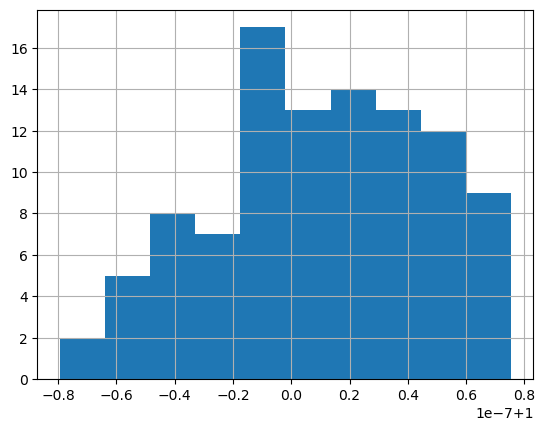

In [35]:
df['distance'].hist()

In [ ]:
df_full = pd.read_csv('/Users/arad/repos/pp_kaggle_query/csvs/DatasetVersions.csv')
df_full.info()

In [ ]:

# how to save the embeddings

# keep all the embeddings in memory

# make it possible for a user to write a description, vectorize the description, and find similar datasets.


"""
function
input: vector - users vectorized query, a collection of dataset vectors

output: distances, datasetid (maybe just top 5 shortest distances)
"""

def process_user_query(user_query,dataset_embeddings):

    user_embedding = get_embedding(user_query, model=embedding_model)

    # take the distance between user_embedding and all dataset embeddings

    # dist = numpy.linalg.norm(a-b)

    dataset_embeddings['distance'] = df['embedding'].apply(lambda x: np.linalg.norm(x - user_embedding))

    dataset_embeddings.sort_values(by='distance', ascending=True, inplace=True)

    return df.iloc[0:5,:]['DatasetId'].values

"""
function
input: distances, datasetid (maybe just top 5 shortest distances)

output: dataset name, url, ...
"""

def get_dataset_info(top_5_datasets_array,dataset_df):

    subset_df = dataset_df.loc[dataset_df['DatasetId'].isin(top_5_datasets_array),["Title","Subtitle","Description"]]

    for index, row in subset_df.iterrows():
        print(row['Title'])
        print(row["Subtitle"])
        print("*"*100)
        print("\n")
        print("Dataset Description:\n")
        print(row['Description'])
    


test_query = "i am really interested in doing an analysis on indian crop yields."

test_array = process_user_query(test_query,df)

get_dataset_info(test_array,df_full)

In [56]:
# www.kaggle.com/datasets/user/dataset-slug
df_full['Slug'].head()

0    2013-american-community-survey
1     climate-data-from-ocean-ships
2                       meta-kaggle
3            hillary-clinton-emails
4                 college-scorecard
Name: Slug, dtype: object

In [ ]:
"""
---> 23 dataset_embeddings['distance'] = df['embedding'].apply(lambda x: np.linalg.norm(x - user_embedding))
     25 dataset_embeddings.sort_values(by='distance', ascending=True, inplace=True)
     27 return dataset_embeddings.iloc[0:5,'DatasetId']

TypeError: unsupported operand type(s) for -: 'list' and 'list'

"""

# it's all right here! what did we do wrong?

In [57]:
pd.read_csv('/Users/arad/repos/pp_kaggle_query/csvs/Users.csv')
# looks like we have everything we need to construct dataset urls

,Id,UserName,DisplayName,RegisterDate,PerformanceTier
0,1,kaggleteam,Kaggle Team,03/24/2011,5
1,368,antgoldbloom,Anthony Goldbloom,01/20/2010,2
2,381,iguyon,Isabelle,01/29/2010,2
3,383,davidstephan,David Stephan,02/01/2010,0
4,384,gabewarren,Gabe Warren,02/02/2010,0
...,...,...,...,...,...
18246552,20750121,rajukancham,RAJU KANCHAM,05/08/2024,0
18246553,20750122,elfiradiva,Elfira Diva Yuniarti,05/08/2024,0
18246554,20750123,cbe110023,CBE110023,05/08/2024,0
18246555,20750124,alanponce987,Alan Ponce,05/08/2024,0


In [2]:
# which dataset descriptions are not worthy of being embedded
import pandas as pd
df_full = pd.read_csv('/Users/arad/repos/pp_kaggle_query/csvs/DatasetVersions.csv')
df_full.info()


# how much will cost to embed the worthy ones

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104888 entries, 0 to 1104887
Data columns (total 14 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Id                      1104888 non-null  int64  
 1   DatasetId               1104888 non-null  int64  
 2   DatasourceVersionId     1104888 non-null  int64  
 3   CreatorUserId           1104888 non-null  int64  
 4   LicenseName             1104888 non-null  object 
 5   CreationDate            1104888 non-null  object 
 6   VersionNumber           1030293 non-null  float64
 7   Title                   1104887 non-null  object 
 8   Slug                    1104888 non-null  object 
 9   Subtitle                588510 non-null   object 
 10  Description             503725 non-null   object 
 11  VersionNotes            1040699 non-null  object 
 12  TotalCompressedBytes    1030331 non-null  float64
 13  TotalUncompressedBytes  1030458 non-null  float64
dtypes:

In [3]:
df_full.dropna(inplace = True)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 475389 entries, 20 to 1104886
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      475389 non-null  int64  
 1   DatasetId               475389 non-null  int64  
 2   DatasourceVersionId     475389 non-null  int64  
 3   CreatorUserId           475389 non-null  int64  
 4   LicenseName             475389 non-null  object 
 5   CreationDate            475389 non-null  object 
 6   VersionNumber           475389 non-null  float64
 7   Title                   475389 non-null  object 
 8   Slug                    475389 non-null  object 
 9   Subtitle                475389 non-null  object 
 10  Description             475389 non-null  object 
 11  VersionNotes            475389 non-null  object 
 12  TotalCompressedBytes    475389 non-null  float64
 13  TotalUncompressedBytes  475389 non-null  float64
dtypes: float64(3), int64(4)

In [7]:
df_full['DatasetId'].nunique()

61515

In [6]:
df_full.duplicated(subset=['DatasetId']).sum()

413874

In [8]:
# deduplicate by datasetid, taking most recent
df_full["CreationDate"] = pd.to_datetime(df_full["CreationDate"]) # CreationDate::date
df_full.sort_values(by = "CreationDate",ascending=False,inplace=True)

In [10]:
df_full.drop_duplicates(subset = ["DatasetId"],keep='first',inplace=True)

In [11]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61515 entries, 1094215 to 189577
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Id                      61515 non-null  int64         
 1   DatasetId               61515 non-null  int64         
 2   DatasourceVersionId     61515 non-null  int64         
 3   CreatorUserId           61515 non-null  int64         
 4   LicenseName             61515 non-null  object        
 5   CreationDate            61515 non-null  datetime64[ns]
 6   VersionNumber           61515 non-null  float64       
 7   Title                   61515 non-null  object        
 8   Slug                    61515 non-null  object        
 9   Subtitle                61515 non-null  object        
 10  Description             61515 non-null  object        
 11  VersionNotes            61515 non-null  object        
 12  TotalCompressedBytes    61515 non-null  floa

In [12]:
# duplicate descriptions
df_full.duplicated(subset=['Description']).sum()

1077

In [22]:
df_full.loc[df_full['TotalUncompressedBytes'] == 0].shape[0]

55951

In [18]:
61515 - df_full.loc[df_full['TotalUncompressedBytes'] == 0].shape[0]

5564

In [24]:

# guillemservera/
users = pd.read_csv('/Users/arad/repos/pp_kaggle_query/csvs/Users.csv')

In [25]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18246557 entries, 0 to 18246556
Data columns (total 5 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   Id               int64 
 1   UserName         object
 2   DisplayName      object
 3   RegisterDate     object
 4   PerformanceTier  int64 
dtypes: int64(2), object(3)
memory usage: 696.1+ MB


In [26]:
users.loc[users['Id'] == 6047420,:]

,Id,UserName,DisplayName,RegisterDate,PerformanceTier
5566655,6047420,guillemservera,Guillem SD,10/27/2020,2


In [27]:
df_full['char_count'] = df_full['Description'].apply(len)

In [31]:
df_full['char_count'].describe()

count    6.151500e+04
mean     1.397545e+03
std      8.231841e+03
min      1.000000e+00
25%      3.740000e+02
50%      7.740000e+02
75%      1.561000e+03
max      1.955338e+06
Name: char_count, dtype: float64

In [35]:
df_full.loc[df_full['char_count'] < 10,:].sort_values(by = 'char_count',ascending=False).to_csv('short_descriptions.csv')